In [10]:
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [37]:
class LinearActivation(nn.Module):
    def __init__(self, vmin, vmax):
        super(LinearActivation, self).__init__()
        self.vmin = vmin
        self.vmax = vmax

    def forward(self, input):
        return torch.clamp(input, self.vmin, self.vmax)
    
    def draw(self, weights, vmin, vmax, scale=2):
        x = torch.linspace(scale*vmin, scale*vmax, 1001, dtype=weights.dtype).unsqueeze_(0)
        x = x.repeat(weights.shape[0], 1)
        f_x =  self.forward(x)
        return x, f_x


In [38]:
def projection_onto_grad_bound(x, A, gmin, gmax, num_max_iter=3000, stopping_value=1e-8):
    # compute the Lipschitz constant
    L = np.linalg.norm(np.dot(A, A.T), 2)

    # transform the input to numpy
    np_x = x.detach().cpu().numpy().T
    np_x_bar = np_x.copy()

    # define the Lagrange duals
    np_l = np.zeros((A.shape[0], np_x.shape[1]), dtype=np.float32)
    # use Fista
    np_l_old = np_l.copy()

    for k in range(1,num_max_iter+1):
        beta = (k - 1) / (k + 2)
        np_l_hat = np_l + beta * (np_l - np_l_old)
        np_l_old = np_l.copy()

        grad_l = np.dot(A, np.dot(A.T, np_l_hat) - np_x_bar)
        np_l_hat = np_l_hat - grad_l/L
        np_l = np_l_hat - 1./L * np.maximum(gmin, np.minimum(gmax, np_l_hat * L))

        np_x_old = np_x.copy()
        np_x = np_x_bar - np.dot(A.T, np_l)

        np_diff = np.sqrt(np.mean((np_x_old - np_x) ** 2))

        if k > 1 and np_diff < stopping_value:
            break

    if np_diff > stopping_value:
        print('   Projection onto linear constraints: %d/%d iterations' % (k, num_max_iter))

    x.data = torch.as_tensor(np_x.T, dtype=x.dtype, device=x.device)

In [39]:
class TrainableActivation(nn.Module):
    def __init__(self, num_channels, vmin, vmax, num_weights, init_scale=1.0,
                 group=1, bmin=None, bmax=None, gmin=None, gmax=None):
        super(TrainableActivation, self).__init__()

        self.num_channels = num_channels
        self.vmin = vmin
        self.vmax = vmax
        self.num_weights = num_weights
        self.init_scale = init_scale
        self.group = group
        self.bmin = bmin
        self.bmax = bmax
        self.gmin = gmin
        self.gmax = gmax
     
        # setup the parameters of the layer
        self.weight = nn.Parameter(torch.Tensor(self.num_channels, self.num_weights))
        self.reset_parameters()

        # define the reduction index
        self.weight.reduction_dim = (1, )
        # possibly add a projection function
        # self.weight.proj = lambda _: pass



        delta_x = (self.vmax - self.vmin) / (self.num_weights - 1)

        eye = np.eye(self.num_weights)
        forward_differences = (np.diag(-np.ones((self.num_weights,)), k=0)[:-1, :] +
                                np.diag(np.ones(self.num_weights - 1, ), k=1)[:-1, :]) / delta_x
        A = np.vstack((eye, forward_differences))
        lower_bound = np.vstack((
            bmin * np.ones((self.num_weights, self.num_channels), dtype=np.float32),
            gmin * np.ones((self.num_weights-1, self.num_channels), dtype=np.float32)
        ))
        upper_bound = np.vstack((
            bmax * np.ones((self.num_weights, self.num_channels), dtype=np.float32),
            gmax * np.ones((self.num_weights-1, self.num_channels), dtype=np.float32)
        ))
        self.weight.proj = lambda: projection_onto_grad_bound(self.weight, A, 
                        lower_bound, upper_bound)
        # set the operator to linear
        self.op = LinearActivation(self.vmin, self.vmax)
        

    def reset_parameters(self):
        # define the bins
        np_x = np.linspace(self.vmin, self.vmax, self.num_weights, dtype=np.float32)[np.newaxis, :]
        
        np_w = np_x * self.init_scale

        # tile to proper size
        np_w = np.tile(np_w, (self.num_channels, 1))

        self.weight.data = torch.from_numpy(np_w)

    def forward(self, x):
        # first reshape the input
        x = x.transpose(0, 1).contiguous()
        if x.shape[0] % self.group != 0:
            raise RuntimeError("Input shape must be a multiple of group!") 
        x_r = x.view(x.shape[0]//self.group, -1)
        # compute the output
        x_r = self.op.apply(x_r, self.weight, self.base_type, self.vmin, self.vmax)
        return x_r.view(x.shape).transpose_(0, 1)

    def draw(self, scale=2):
        return self.op.draw(self.weight, self.vmin, self.vmax, scale=scale)

    def extra_repr(self):
        s = "num_channels={num_channels}, num_weights={num_weights}, type={base_type}, vmin={vmin}, vmax={vmax}, init={init}, init_scale={init_scale}"
        s += " group={group}, bmin={bmin}, bmax={bmax}, gmin={gmin}, gmax={gmax}, norm={norm}, tv2<={tv2}, symmetric={symmetric}"
        return s.format(**self.__dict__)

In [57]:
train_act = TrainableActivation(1, -20, 20, 256,bmin=5 ,bmax=1, gmin=1, gmax=1)

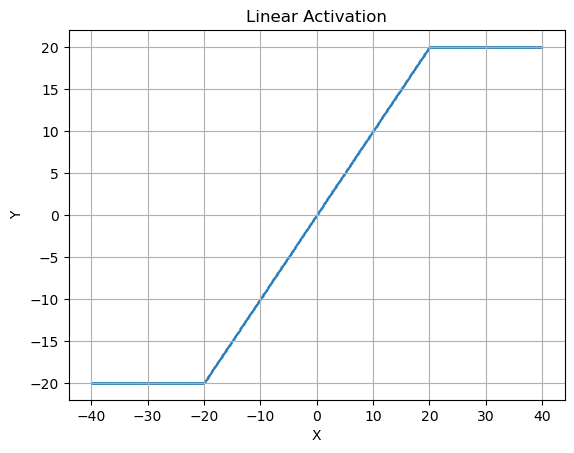

In [58]:
x, y = train_act.draw()
x = x.detach().numpy()
y = y.detach().numpy()
# Plot the coordinates
plt.scatter(x, y, s=1, marker=".")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Activation')
plt.grid(True)
plt.show()